In [19]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

def segment_cells(filename, do_plot: bool = False):
    img = cv.imread(filename)[20:-20,10:-10]
    assert img is not None, "file could not be read, check with os.path.exists()"

    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    # noise removal
    kernel = np.ones((4,4),np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations = 1)
    
    # sure background area
    sure_bg = cv.dilate(opening, kernel, iterations=1)

    # Finding sure foreground area
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    _, sure_fg = cv.threshold(dist_transform, 0.7, 1, cv.THRESH_BINARY)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv.connectedComponents(sure_fg, connectivity=8)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    markers = cv.watershed(img,markers)
    img_marked = np.array(img)
    img_marked[markers == -1] = [255,0,0]
    
    if do_plot:
        # Plotting
        fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(16, 18))
        ax0.set_axis_off()
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax3.set_axis_off()
        ax4.set_axis_off()
        ax5.set_axis_off()

        ax0.imshow(img)
        ax1.imshow(thresh)
        ax2.imshow(dist_transform, cmap="gray")
        ax3.imshow(sure_fg, cmap="gray")
        ax4.imshow(markers, cmap="Set3")
        ax5.imshow(img_marked)
        for n_marker in np.unique(markers):
            if  n_marker > 1:
                x, y = np.nonzero((markers==n_marker).T)
                coords = np.array([x, y])
                middle = np.mean(coords, axis=1)
                circle = Circle(
                    middle,
                    radius=10,
                    facecolor="white",
                    edgecolor="k",
                )
                ax4.add_patch(circle)
                label = ax4.annotate(
                    str(n_marker),
                    xy=middle,
                    fontsize=10,
                    verticalalignment="center",
                    horizontalalignment="center"
                )
        print("Estimated {} cells are present".format(len(np.unique(markers))-2))

        fig.tight_layout()
    return markers, img

def count_cells(filename) -> int:
    markers, img = segment_cells(filename)
    return len(np.unique(markers))-2

def segment_cells_2(filename):
    fig, ax = plt.subplots(2, 2, figsize=(16,12))
    img = cv.imread(filename)[20:-20,20:-20]
    assert img is not None, "file could not be read, check with os.path.exists()"

    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    _, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8) 
    eroded = cv.erode(thresh, kernel, iterations=2)
    img_dilation = cv.dilate(eroded, kernel, iterations=1)

    ret, markers = cv.connectedComponents(img_dilation)
    print(ret)
    
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    
    # Now, mark the region of unknown with zero
    markers[eroded==0] = 0

    markers = cv.watershed(img,markers)
    img_marked = np.array(img)
    img_marked[markers == -1] = [255,0,0]

    ax[0,0].imshow(img)
    ax[0,1].imshow(eroded)
    ax[1,0].imshow(img_dilation)
    ax[1,1].imshow(markers)

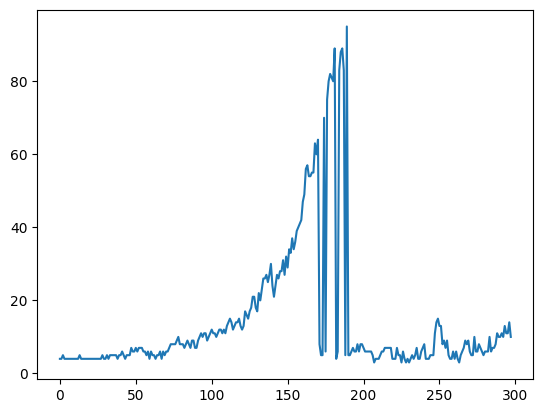

In [20]:
from glob import glob
import scipy as sp

values = np.array([count_cells(filename) for filename in sorted(list(glob('data/growth-2/*.png')))], dtype=float)
plt.plot(values)

Estimated 15 cells are present


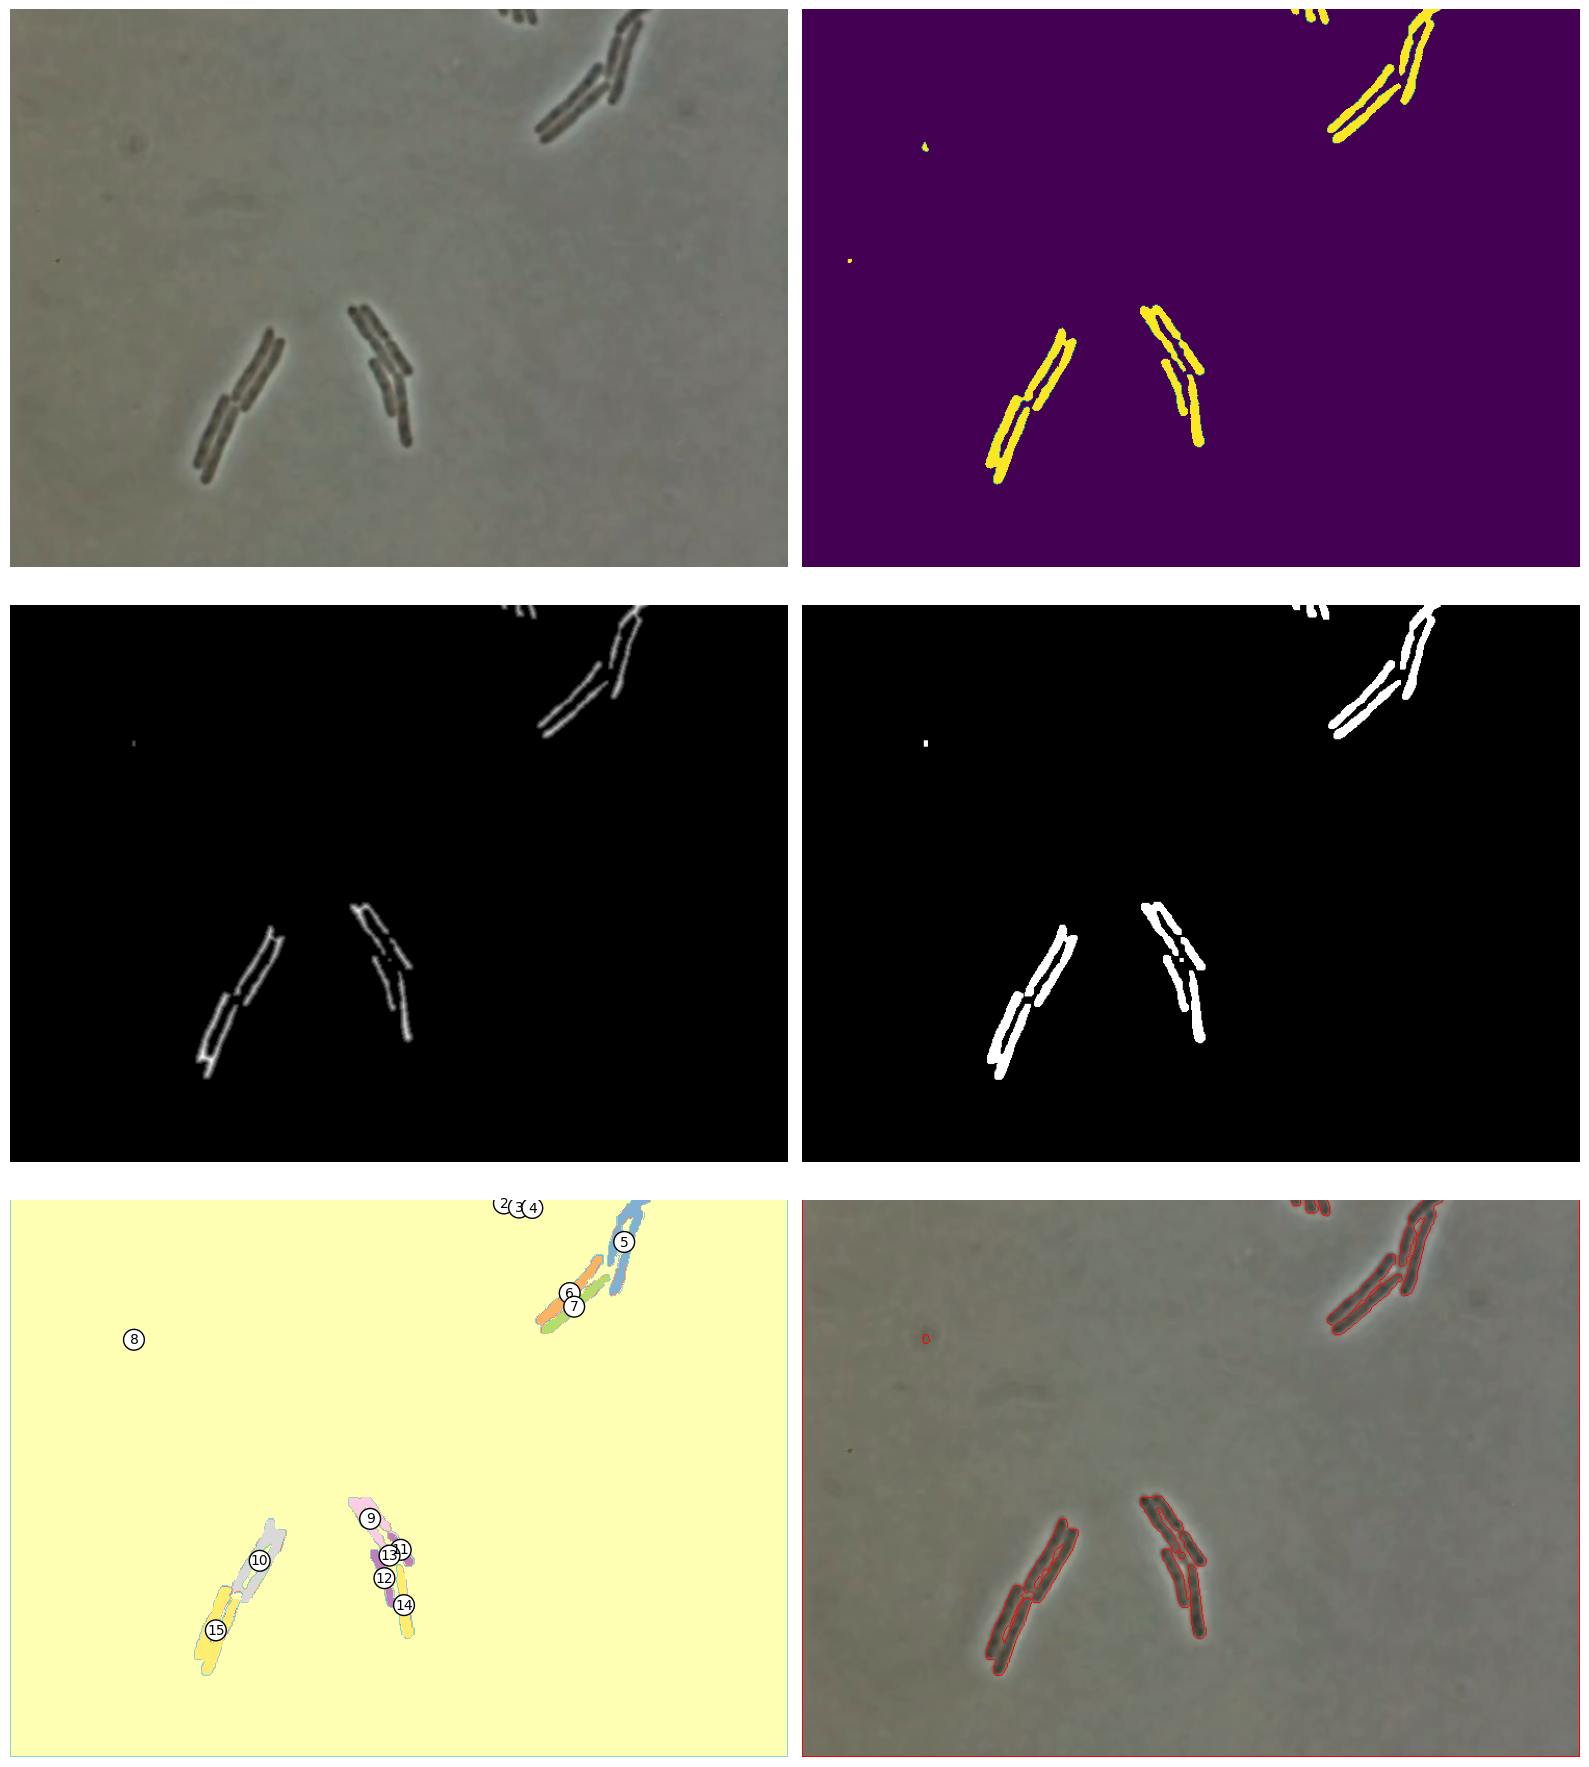

In [21]:
_ = segment_cells('data/growth-2/image001110.png', do_plot=True)

In [22]:
import copy

import imageio
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

from deepcell.applications import NuclearSegmentation, CellTracking
from deepcell.datasets import DynamicNuclearNetSample

ModuleNotFoundError: No module named 'imageio'